In [4]:
# Reference | https://herbwood.tistory.com/11

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

In [5]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print(DEVICE, torch.cuda.get_device_name(0))
else:
    DEVICE = torch.device('cpu')
    print(DEVICE)

cuda NVIDIA GeForce GTX 1660 SUPER


(1333, 2000, 3)


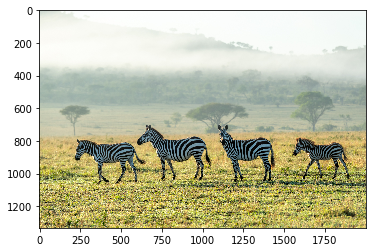

In [6]:
img0 = cv2.imread('./zebras.jpg')
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
print(img0.shape)

plt.imshow(img0)
plt.show()

In [7]:
bbox0 = np.array([[223, 782, 623, 1074], [597, 695, 1038, 1050], 
                  [1088, 699, 1452, 1057], [1544, 771, 1914, 1063]])
labels = np.array([1, 1, 1, 1])

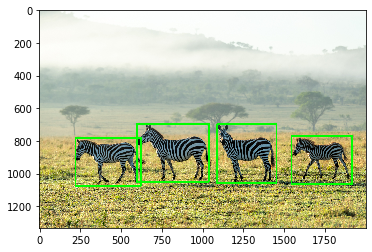

In [8]:
img0_clone = np.copy(img0)

for i in range(len(bbox0)):
    cv2.rectangle(img0_clone, (bbox0[i][0], bbox0[i][1]), (bbox0[i][2], bbox0[i][3]), color=(0, 255, 0), thickness=10)
plt.imshow(img0_clone)
plt.show()

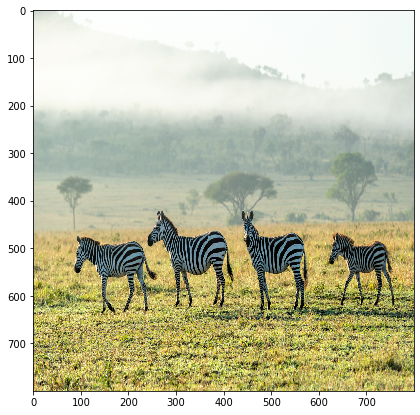

In [9]:
img = cv2.resize(img0, dsize=(800, 800), interpolation=cv2.INTER_CUBIC)
plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.show()

0.4 0.6001500375093773
[[ 89 469 249 644]
 [238 417 415 630]
 [435 419 580 634]
 [617 462 765 637]]


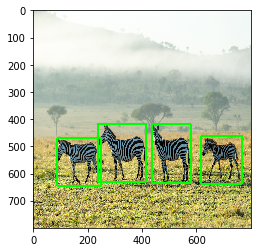

In [10]:
Wratio = 800/img0.shape[1]
Hratio = 800/img0.shape[0]

print(Wratio, Hratio)

ratioList = [Wratio, Hratio, Wratio, Hratio]
bbox = []

for box in bbox0:
    box = [int(a*b) for a, b in zip(box, ratioList)]
    bbox.append(box)
    
bbox = np.array(bbox)
print(bbox)

img_clone = np.copy(img)
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), color=(0, 255, 0), thickness=5)
plt.imshow(img_clone)
plt.show()

In [12]:
model = torchvision.models.vgg16(pretrained=True).to(DEVICE)
features = list(model.features)
print(len(features))
print(features)

31
[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [13]:
dummy_image = torch.zeros((1, 3, 800, 800)).float()

req_features = []
output = dummy_image.clone().to(DEVICE)

for feature in features:
    output = feature(output)
    if output.size()[2] < 800//16:
        break
    req_features.append(feature)
    out_channels = output.size()[1]

print(len(req_features))
print(out_channels)

30
512


C:\Users\Wooj\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [14]:
faster_rcnn_feature_extractor = nn.Sequential(*req_features)

In [15]:
transform = transforms.Compose([transforms.ToTensor()])
imgTensor = transform(img).to(DEVICE)
imgTensor = imgTensor.unsqueeze(0)
output_map = faster_rcnn_feature_extractor(imgTensor)
print(output_map.size())

torch.Size([1, 512, 50, 50])


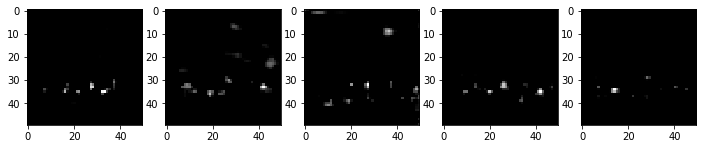

In [16]:
imgArray = output_map.data.cpu().numpy().squeeze(0)
fig = plt.figure(figsize=(12, 4))
figNo = 1

for i in range(5):
    fig.add_subplot(1, 5, figNo)
    plt.imshow(imgArray[i], cmap='gray')
    figNo += 1

plt.show()

In [17]:
feature_size = 800 // 16
ctr_x = np.arange(16, (feature_size + 1) * 16, 16)
ctr_y = np.arange(16, (feature_size + 1) * 16, 16)
print(len(ctr_x))
print(ctr_x)

50
[ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [18]:
index = 0
ctr = np.zeros((2500, 2))

for i in range(len(ctr_x)):
    for j in range(len(ctr_y)):
        ctr[index, 1] = ctr_x[i] - 8
        ctr[index, 0] = ctr_y[j] - 8
        index += 1

print(ctr.shape)
print(ctr[:10, :])

(2500, 2)
[[  8.   8.]
 [ 24.   8.]
 [ 40.   8.]
 [ 56.   8.]
 [ 72.   8.]
 [ 88.   8.]
 [104.   8.]
 [120.   8.]
 [136.   8.]
 [152.   8.]]


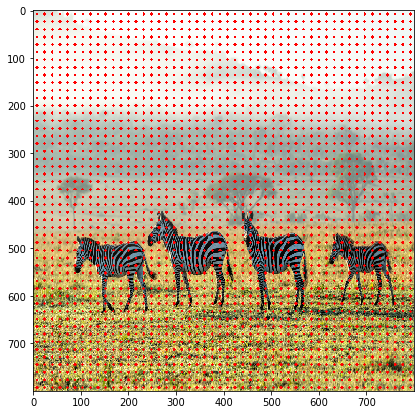

In [19]:
img_clone2 = np.copy(img)
ctr_int = ctr.astype('int32')

plt.figure(figsize=(7, 7))

for i in range(ctr.shape[0]):
    cv2.circle(img_clone2, (ctr_int[i][0], ctr_int[i][1]),
               radius=1, color=(255, 0, 0), thickness=3)

plt.imshow(img_clone2)
plt.show()

In [20]:
ratios = [0.5, 1, 2]
scales = [8, 16, 32]
sub_sample = 16

anchor_boxes = np.zeros(((feature_size * feature_size * 9), 4))
index = 0

for c in ctr:
    ctr_y, ctr_x = c
    for i in range(len(ratios)):
        for j in range(len(scales)):
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1./ratios[i])

            anchor_boxes[index, 1] = ctr_y - h / 2.
            anchor_boxes[index, 0] = ctr_x - w / 2.
            anchor_boxes[index, 3] = ctr_y + h / 2.
            anchor_boxes[index, 2] = ctr_x + w / 2.
            index += 1

print(anchor_boxes.shape)
print(anchor_boxes[:10, :])

(22500, 4)
[[ -82.50966799  -37.254834     98.50966799   53.254834  ]
 [-173.01933598  -82.50966799  189.01933598   98.50966799]
 [-354.03867197 -173.01933598  370.03867197  189.01933598]
 [ -56.          -56.           72.           72.        ]
 [-120.         -120.          136.          136.        ]
 [-248.         -248.          264.          264.        ]
 [ -37.254834    -82.50966799   53.254834     98.50966799]
 [ -82.50966799 -173.01933598   98.50966799  189.01933598]
 [-173.01933598 -354.03867197  189.01933598  370.03867197]
 [ -82.50966799  -21.254834     98.50966799   69.254834  ]]


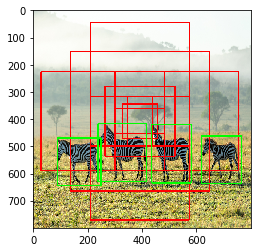

In [22]:
img_clone = np.copy(img)

for i in range(11025, 11034):
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])

    cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=3)

for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), color=(0, 255, 0), thickness=3)
plt.imshow(img_clone)
plt.show()

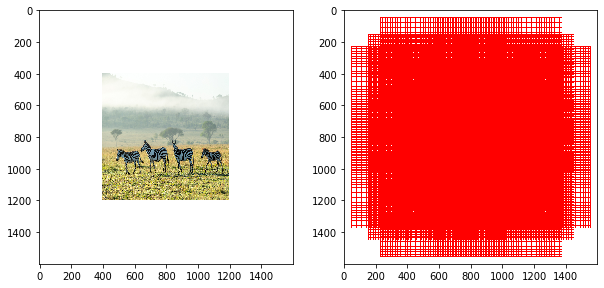

In [23]:
img_clone3 = np.copy(img)
img_clone4 = cv2.copyMakeBorder(img_clone3, 400, 400, 400, 400, cv2.BORDER_CONSTANT, value=(255, 255, 255))
img_clone5 = np.copy(img_clone4)

for i in range(len(anchor_boxes)):
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])
    
    cv2.rectangle(img_clone5, (x1 + 400, y1+400), (x2 + 400, y2 + 400), color=(255, 0, 0),
                 thickness=3)

plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(img_clone4)
plt.subplot(122), plt.imshow(img_clone5)
plt.show()

In [24]:
index_inside = np.where(
        (anchor_boxes[:, 0] >= 0) &
        (anchor_boxes[:, 1] >= 0) &
        (anchor_boxes[:, 2] <= 800) &
        (anchor_boxes[:, 3] <= 800))[0]

print(index_inside.shape)

(8940,)


In [25]:
valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)

(8940, 4)


In [26]:
ious = np.empty((len(valid_anchor_boxes),4), dtype=np.float32)
ious.fill(0)

for i, anchor_box in enumerate(valid_anchor_boxes):
    xa1, ya1, xa2, ya2 = anchor_box
    anchor_area = (xa2 - xa1) * (ya2 - ya1)

    for j, gt_box in enumerate(bbox):
        xb1, yb1, xb2, yb2 = gt_box
        box_area = (xb2 - xb1) * (yb2 - yb1)
        
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            inter_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)
            iou = inter_area / (anchor_area + box_area - inter_area)
        else:
            iou = 0
        
        ious[i, j] = iou
        
print(ious.shape)
print(ious[8930:8940, :])

(8940, 4)
[[0.         0.         0.         0.37780452]
 [0.         0.         0.         0.33321926]
 [0.         0.         0.         0.29009855]
 [0.         0.         0.         0.24967977]
 [0.         0.         0.         0.2117167 ]
 [0.         0.         0.         0.17599213]
 [0.         0.         0.         0.14231375]
 [0.         0.         0.         0.11051063]
 [0.         0.         0.         0.08043041]
 [0.         0.         0.         0.05193678]]


In [27]:
gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)

gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

[1008 2862 5935 8699]
[0.58514285 0.5752716  0.5255493  0.6325869 ]
[1008 1013 1018 1226 1232 1238 2862 2869 2876 3108 3115 3122 3336 3343
 3350 3354 3357 3361 3364 3368 3371 3377 3383 3389 3600 3607 3614 3846
 3853 3860 5935 5942 6164 6171 6178 6181 6185 6188 6192 6198 6427 6434
 8699 8703 8707]


In [28]:
argmax_ious = ious.argmax(axis=1)
print(argmax_ious.shape)
print(argmax_ious)

max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious)

(8940,)
[0 0 0 ... 3 3 3]
[0.         0.         0.         ... 0.11051063 0.08043041 0.05193678]


In [29]:
label = np.empty((len(index_inside),), dtype=np.int32)
label.fill(-1)
print(label.shape)

(8940,)


In [30]:
pos_iou_threshold = 0.7
neg_iou_threshold = 0.3

label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold] = 1
label[max_ious < neg_iou_threshold] = 0

In [31]:
n_sample = 256
pos_ratio = 0.5
n_pos = pos_ratio * n_sample

pos_index = np.where(label == 1)[0]

if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index,
                                    size = (len(pos_index) - n_pos),
                                    replace=False)
    label[disable_index] = -1
    
n_neg = n_sample * np.sum(label == 1)
neg_index = np.where(label == 0)[0]

if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, 
                                    size = (len(neg_index) - n_neg), 
                                    replace = False)
    label[disable_index] = -1

In [32]:
max_iou_bbox = bbox[argmax_ious]
print(max_iou_bbox.shape)

height = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
width = valid_anchor_boxes[:, 2] = valid_anchor_boxes[:, 0]
ctr_y = valid_anchor_boxes[:, 1] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 0] + 0.5 * width

base_height = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_width = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_ctr_y = max_iou_bbox[:, 1] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 0] + 0.5 * base_width

eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)

anchor_locs = np.vstack((dx, dy, dw, dh)).transpose()
print(anchor_locs.shape)

(8940, 4)
(8940, 4)


In [33]:
anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print(anchor_labels.shape)
print(anchor_labels[:10])

anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside, :] = anchor_locs
print(anchor_locations.shape)
print(anchor_locations[:10, :])

(22500,)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(22500, 4)
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [34]:
in_channels = 512
mid_channels = 512
n_anchor = 9

conv1 =nn.Conv2d(in_channels, mid_channels, 3, 1, 1).to(DEVICE)
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

reg_layer = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0).to(DEVICE)
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

cls_layer = nn.Conv2d(mid_channels, n_anchor * 2, 1, 1, 0).to(DEVICE)
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')

In [35]:
x = conv1(output_map.to(DEVICE))
pred_anchor_locs = reg_layer(x)
pred_cls_scores = cls_layer(x)

print(pred_anchor_locs.shape, pred_cls_scores.shape)

torch.Size([1, 36, 50, 50]) torch.Size([1, 18, 50, 50])


In [36]:
pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)

torch.Size([1, 22500, 4])


In [37]:
pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores.shape)

torch.Size([1, 50, 50, 18])


In [38]:
objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)

In [39]:
pred_cls_scores = pred_cls_scores.view(1, -1, 2)

In [40]:
rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]

gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)

In [41]:
rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_score.long().to(DEVICE), ignore_index=-1)
print(rpn_cls_loss)

tensor(0.6927, device='cuda:0', grad_fn=<NllLossBackward>)


In [42]:
pos = gt_rpn_score > 0
mask = pos.unsqueeze(1).expand_as(rpn_loc)
mask_loc_preds = rpn_loc[mask].view(-1, 4)
mask_loc_targets = gt_rpn_loc[mask].view(-1, 4)

In [43]:
x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
rpn_loc_loss = ((x < 1).float() * 0.5 * x ** 2) + ((x >= 1).float() * (x - 0.5))

In [44]:
rpn_lambda = 10
N_reg = (gt_rpn_score > 0).float().sum()
rpn_loc_loss = rpn_loc_loss.sum() / N_reg
rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss)
print(rpn_loss)

tensor(4.6857, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
